In [2]:
# Bibliotecas necesarias
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
import torch
from transformers import BertTokenizer, BertModel
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from wordcloud import WordCloud
from collections import Counter
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import warnings
warnings.filterwarnings('ignore')

# Configuración visual profesional
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_context("talk", font_scale=1.1)

# Paleta de colores profesional
colores = ["#1f77b4", "#ff7f0e", "#2ca02c", "#d62728", "#9467bd",
           "#8c564b", "#e377c2", "#7f7f7f", "#bcbd22", "#17becf"]

nltk.download('stopwords')
nltk.download('punkt')


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\tobar\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\tobar\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [3]:
url = "https://github.com/Carot2/MaestriaAnaliticaDatos/raw/c181d78bb214cd719fe04386fc90628b6e7922e4/dataset_ong2.xlsx"
df = pd.read_excel(url)
print("Datos cargados exitosamente")
df.head()


Datos cargados exitosamente


,Fecha,Municipio,Sector,Categoria,Reporte,Resolucion
0,2023-08-25 16:07:01,Ocana,Educacion,Retroalimentación positiva,MI OPINION ES TOTALMENTE POSITIVO PARA QUE BUE...,SE DIFUNDE EL MENSAJE DE MANERA INTERNA
1,2023-08-25 16:09:23,Ocana,Educacion,Retroalimentación positiva,MI OPINION ES QUE LUCHEN POR EL TRABAJO PARA Q...,SE DIFUNDE EL MENSAJE DE MANERA INTERNA
2,2023-06-09 14:54:43,Soacha,Salud Nutricion,Retroalimentación positiva,FECHA DE ACTIVIDAD 25/05/2023 RECIBIDO POR RE...,SE DIFUNDE MSJ
3,2023-07-24 19:50:35,Barbacoas,Proteccion,Retroalimentación positiva,NO TENGO NADA QUE DECIR PERO ESTAR AQUI ME PON...,SE DIFUNDE EL MENSAJE DE MANERA INTERNA
4,2023-07-24 19:58:07,Barbacoas,Proteccion,Retroalimentación positiva,ME GUSTO MUCHO LA ACTIVIDAD DEL DIA DE HOY DEB...,SE DIFUNDE EL MENSAJE DE MANERA INTERNA


In [4]:
import re

def limpiar_texto(texto):
    if isinstance(texto, str):
        texto = texto.lower()
        texto = re.sub(r'[^\w\s.,;:!?¿¡]', '', texto)
        texto = re.sub(r'\s+', ' ', texto).strip()
        return texto
    return ''

df['Reporte_limpio'] = df['Reporte'].apply(limpiar_texto)
df[['Reporte', 'Reporte_limpio']].head(3)


,Reporte,Reporte_limpio
0,MI OPINION ES TOTALMENTE POSITIVO PARA QUE BUE...,mi opinion es totalmente positivo para que bue...
1,MI OPINION ES QUE LUCHEN POR EL TRABAJO PARA Q...,mi opinion es que luchen por el trabajo para q...
2,FECHA DE ACTIVIDAD 25/05/2023 RECIBIDO POR RE...,fecha de actividad 25052023 recibido por rendi...


Estadísticas descriptivas del texto

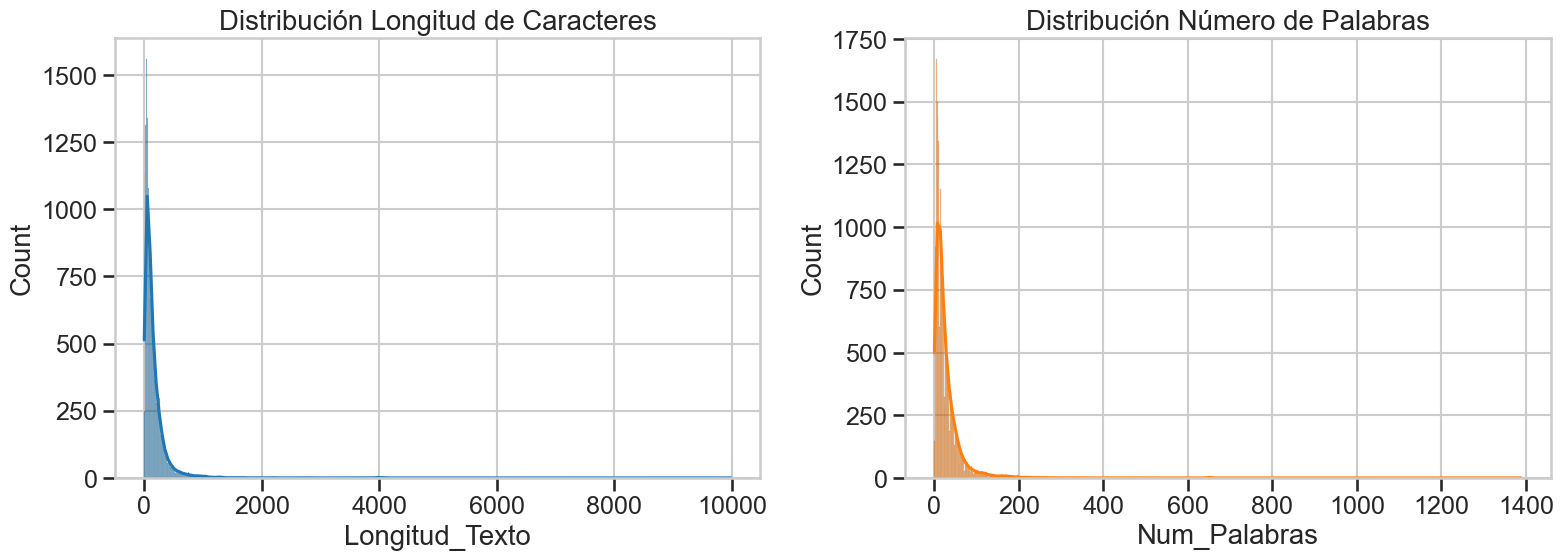

In [5]:
df['Longitud_Texto'] = df['Reporte_limpio'].str.len()
df['Num_Palabras'] = df['Reporte_limpio'].apply(lambda x: len(str(x).split()))

fig, axes = plt.subplots(1, 2, figsize=(16,6))

sns.histplot(df['Longitud_Texto'], kde=True, ax=axes[0], color=colores[0])
axes[0].set_title("Distribución Longitud de Caracteres")

sns.histplot(df['Num_Palabras'], kde=True, ax=axes[1], color=colores[1])
axes[1].set_title("Distribución Número de Palabras")

plt.tight_layout()
plt.show()


Análisis de categorías y gráficos exploratorios

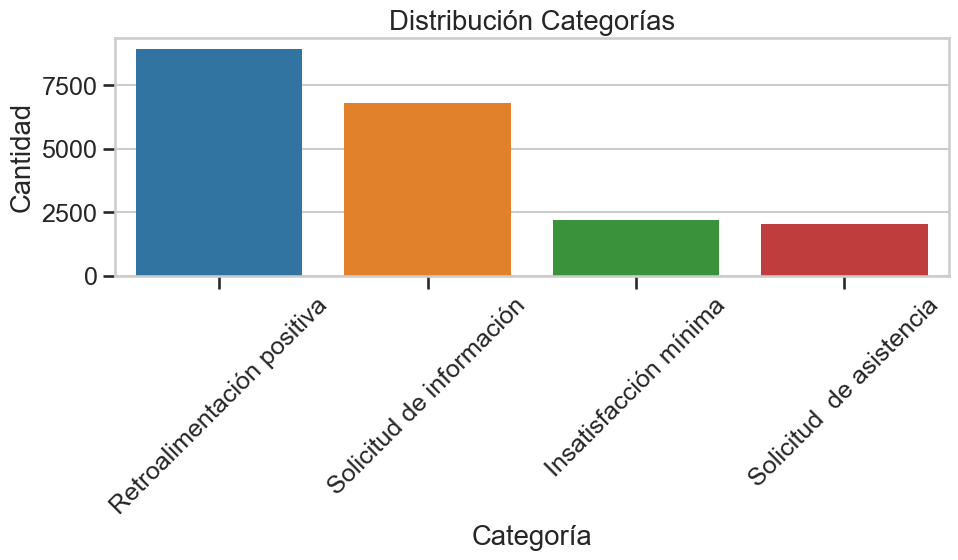

In [6]:
categoria_counts = df['Categoria'].value_counts()

plt.figure(figsize=(10,6))
sns.barplot(x=categoria_counts.index, y=categoria_counts.values, palette=colores[:len(categoria_counts)])
plt.title("Distribución Categorías")
plt.xlabel("Categoría")
plt.ylabel("Cantidad")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


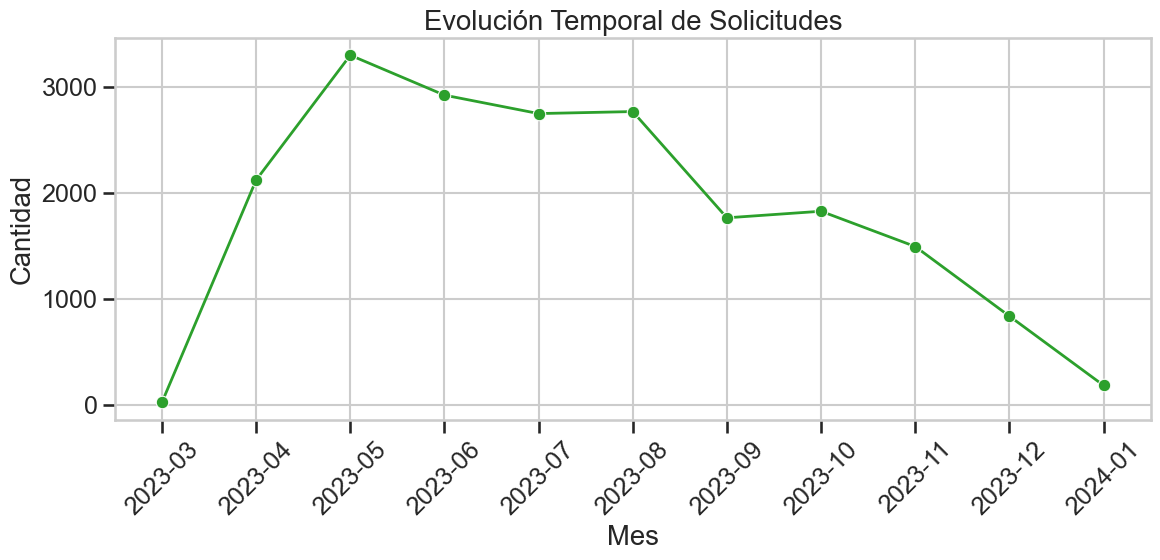

In [7]:
df['Fecha'] = pd.to_datetime(df['Fecha'], errors='coerce')
df['Mes'] = df['Fecha'].dt.to_period('M').astype(str)

temporal = df['Mes'].value_counts().sort_index()

plt.figure(figsize=(12,6))
sns.lineplot(x=temporal.index, y=temporal.values, marker='o', linewidth=2, color=colores[2])
plt.title("Evolución Temporal de Solicitudes")
plt.xlabel("Mes")
plt.ylabel("Cantidad")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()



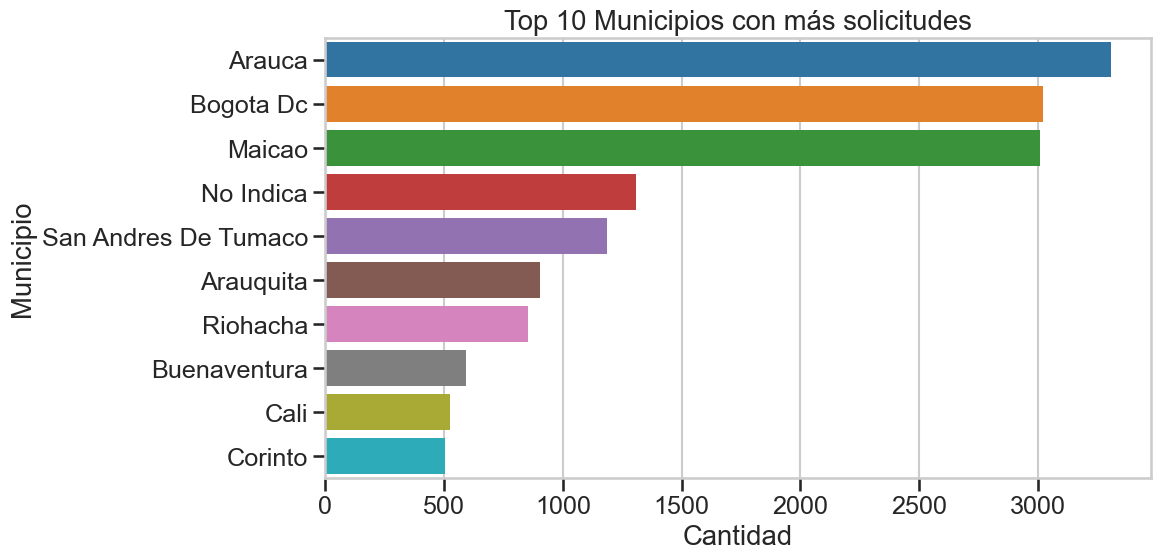

In [8]:
municipios = df['Municipio'].value_counts().head(10)

plt.figure(figsize=(12,6))
sns.barplot(y=municipios.index, x=municipios.values, palette=colores[:len(municipios)])
plt.title("Top 10 Municipios con más solicitudes")
plt.xlabel("Cantidad")
plt.ylabel("Municipio")
plt.tight_layout()
plt.show()

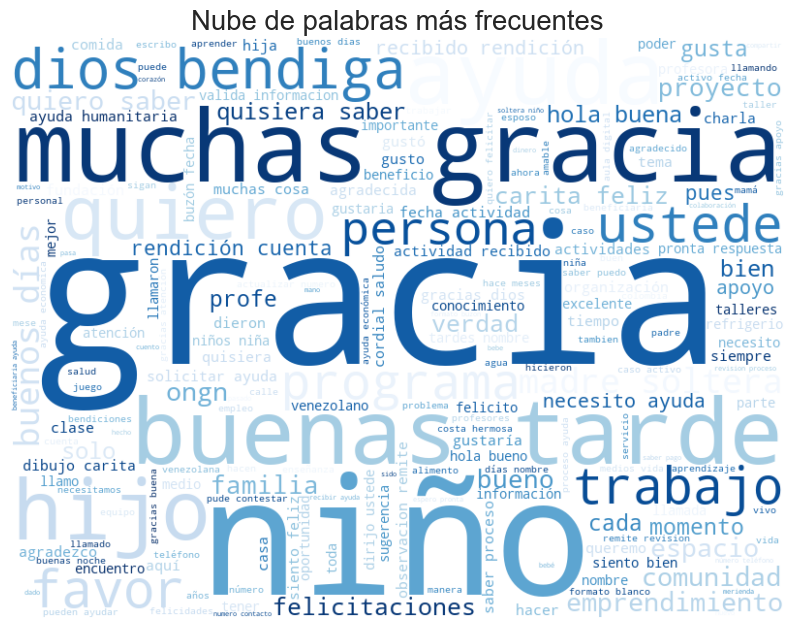

In [9]:
stop_words = set(nltk.corpus.stopwords.words('spanish'))
tokens = nltk.word_tokenize(' '.join(df['Reporte_limpio']))

tokens_filtrados = [word for word in tokens if word not in stop_words and len(word)>3]

wordcloud = WordCloud(width=800, height=600, background_color='white', colormap='Blues').generate(' '.join(tokens_filtrados))

plt.figure(figsize=(10,8))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title("Nube de palabras más frecuentes")
plt.show()


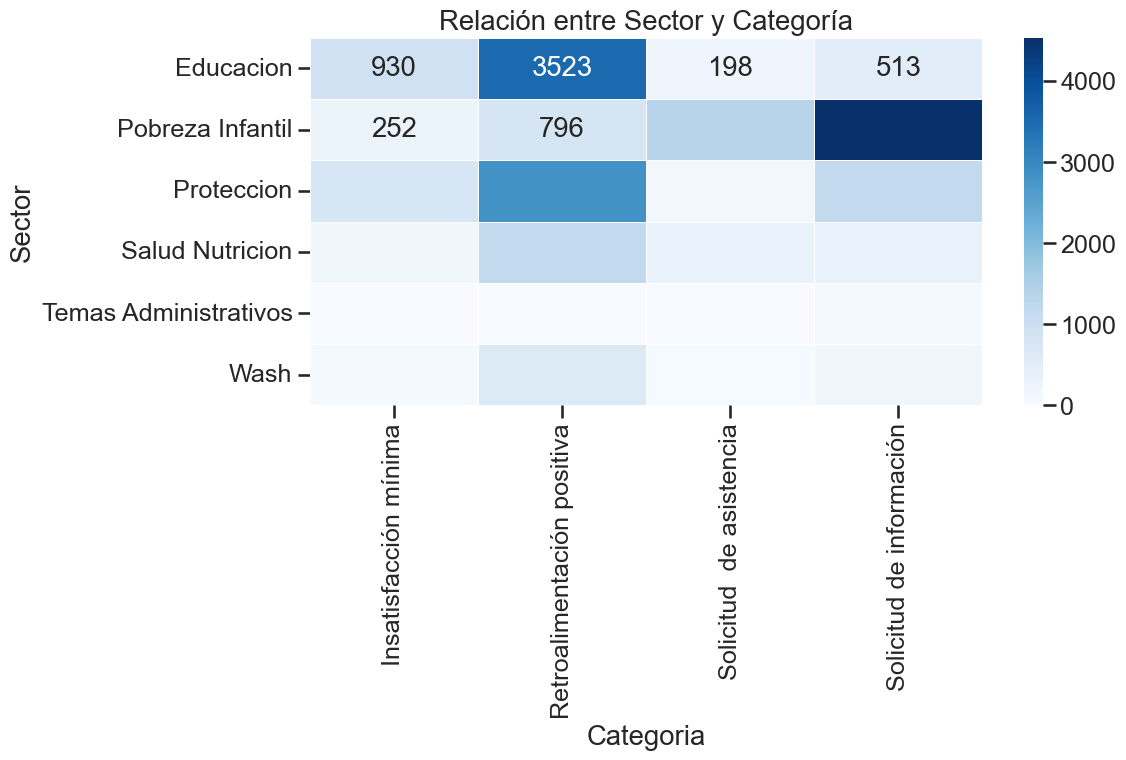

In [10]:
plt.figure(figsize=(12,8))
tabla_contingencia = pd.crosstab(df['Sector'], df['Categoria'])
sns.heatmap(tabla_contingencia, annot=True, cmap='Blues', fmt='d', linewidths=0.5)
plt.title("Relación entre Sector y Categoría")
plt.tight_layout()
plt.show()


In [11]:
X_train, X_test, y_train, y_test = train_test_split(
    df['Reporte_limpio'], df['Categoria'], 
    test_size=0.3, stratify=df['Categoria'], random_state=42
)

label_encoder = LabelEncoder()
y_train_enc = label_encoder.fit_transform(y_train)
y_test_enc = label_encoder.transform(y_test)

print("Datos divididos:")
print(f"Entrenamiento: {X_train.shape[0]} registros")
print(f"Prueba: {X_test.shape[0]} registros")


Datos divididos:
Entrenamiento: 13986 registros
Prueba: 5995 registros


In [12]:
def save_processed_data(train_texts, test_texts, y_train, y_test, label_encoder, file_path='datos_procesados_bert.pt'):
    data_dict = {
        'train_texts': train_texts.tolist(),
        'test_texts': test_texts.tolist(),
        'y_train': y_train.tolist(),
        'y_test': y_test.tolist(),
        'label_encoder_classes': label_encoder.classes_.tolist()
    }
    torch.save(data_dict, file_path)
    print(f"Datos guardados en: {file_path}")

save_processed_data(X_train, X_test, y_train_enc, y_test_enc, label_encoder)


Datos guardados en: datos_procesados_bert.pt


In [13]:
tokenizer = BertTokenizer.from_pretrained('bert-base-multilingual-cased')

ejemplo = X_train.iloc[0]
tokens = tokenizer.tokenize(ejemplo)
token_ids = tokenizer.encode(ejemplo)

print(f"Texto original: {ejemplo}")
print(f"Tokens BERT: {tokens}")
print(f"Token IDs: {token_ids[:10]}...")


tokenizer_config.json:   0%|          | 0.00/49.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/996k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.96M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/625 [00:00<?, ?B/s]

Texto original: hola buenas tardes soy madre soltera de 5 niños me encuentro acá en colombia con mis hijos y mi madre y no tengo trabajo quisiera de que me tomaran en cuenta para la ayuda de corazón me encuentro en bogotá rafael uribe
Tokens BERT: ['hol', '##a', 'buenas', 'tarde', '##s', 'soy', 'madre', 'sol', '##tera', 'de', '5', 'niños', 'me', 'encuentro', 'ac', '##á', 'en', 'col', '##omb', '##ia', 'con', 'mis', 'hijos', 'y', 'mi', 'madre', 'y', 'no', 'ten', '##go', 'trabajo', 'qui', '##sier', '##a', 'de', 'que', 'me', 'tomar', '##an', 'en', 'cuenta', 'para', 'la', 'ayuda', 'de', 'corazón', 'me', 'encuentro', 'en', 'bog', '##ot', '##á', 'ra', '##fa', '##el', 'uri', '##be']
Token IDs: [101, 110516, 10113, 106483, 14002, 10107, 103559, 16282, 15566, 22833]...


In [14]:
fig = px.bar(x=categoria_counts.index, y=categoria_counts.values, color=categoria_counts.index,
             title='Distribución Interactiva Categorías', labels={'x':'Categoría', 'y':'Cantidad'})

fig.update_layout(template='plotly_white', showlegend=False)
fig.show()
